In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pathlib import Path
import shutil

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

dataset_path = '/tf/notebooks/Database'
classes = os.listdir(dataset_path)
class_1 = [ (os.path.join(classes[0], x), os.path.join(dataset_path, classes[0], x)) for x in os.listdir(os.path.join(dataset_path, classes[0])) ]
class_2 = [ (os.path.join(classes[1], x), os.path.join(dataset_path, classes[1], x)) for x in os.listdir(os.path.join(dataset_path, classes[1])) ]
# print(class_size_1, class_size_2)

structdata_path = '/tf/notebooks/Database/struct'
for class_name in classes:
    Path(os.path.join(structdata_path, 'train', class_name)).mkdir( parents=True, exist_ok=True )
    Path(os.path.join(structdata_path, 'valid', class_name)).mkdir( parents=True, exist_ok=True )

# Split 1000 + rest (train + valid)
# 1025 256
# 2616 654

np.random.shuffle(class_1)
for rel_path, src_path in class_1[:1025]:
    shutil.copy(src_path, os.path.join(structdata_path, 'train', rel_path))
for rel_path, src_path in class_1[1025:]:
    shutil.copy(src_path, os.path.join(structdata_path, 'valid', rel_path))
    
np.random.shuffle(class_2)
for rel_path, src_path in class_2[:2616]:
    shutil.copy(src_path, os.path.join(structdata_path, 'train', rel_path))
for rel_path, src_path in class_2[2616:]:
    shutil.copy(src_path, os.path.join(structdata_path, 'valid', rel_path))



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import fastai
import torch

In [4]:
print(torch.__version__)
print(fastai.__version__)

1.13.0+cu116
2.7.10


In [30]:
from fastai.vision import *
from fastai.vision import data as data_io
from fastai import *
from fastai.vision import augment
from fastai.vision import learner
from fastai.callback import tracker
from fastai import metrics
from fastai.test_utils import *
from fastai.vision.data import *
from fastai.vision.all import cnn_learner
from torch.utils.tensorboard import SummaryWriter
from fastai import metrics
from fastai.metrics import F1Score
from fastai.metrics import Precision
from sklearn.metrics import roc_curve, auc




In [6]:
from pathlib import Path
structdata_path = '/tf/notebooks/Database/struct'
path = Path(structdata_path)

In [7]:
np.random.seed(41)
data = data_io.ImageDataLoaders.from_folder(path, train="train", valid ="valid",
        item_tfms=[ augment.Resize((224, 224), method='squish')], bs=32, num_workers=4,
                                           device=torch.device('cuda'))
print(type(data))

<class 'fastai.data.core.DataLoaders'>


In [8]:
len(data.train_ds), len(data.valid_ds)

(3641, 910)

In [9]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 3641
Number of examples in validation: 910


In [10]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

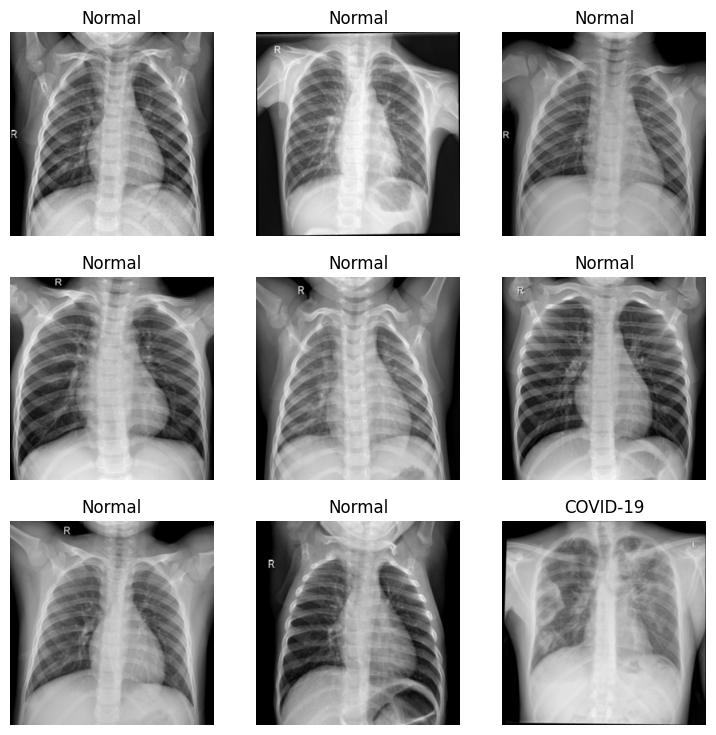

In [11]:
#Sample images from the dataset
data.show_batch()

In [12]:
from torch import nn

In [13]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [14]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [15]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [16]:
def conv_layer(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2)

In [17]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 2),
    nn.Flatten(),
    nn.Linear(338, 2)
)

In [18]:
learn = learner.Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=metrics.accuracy)

In [19]:
print(learn.summary())


Sequential (Input shape: 32 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 8 x 256 x 256  
Conv2d                                    216        True      
BatchNorm2d                               16         True      
LeakyReLU                                                      
____________________________________________________________________________
                     32 x 8 x 128 x 128  
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 16 x 128 x 128 
Conv2d                                    1152       True      
BatchNorm2d                               32         True      
LeakyReLU                                                      
____________________________________________________________________________
                     32 x 16 x 64 x 64   
MaxPool2d                                   

In [20]:
# learn.fit_one_cycle(100, max_lr=3e-3)
learn.fit_one_cycle(25, 0.001)


epoch,train_loss,valid_loss,accuracy,time
0,0.068679,0.027450,0.989011,00:42
1,0.022792,0.023948,0.992308,00:37
2,0.035615,0.081449,0.973626,00:36
3,0.036767,0.533481,0.836264,00:36
4,0.040157,0.040743,0.985714,00:36
5,0.039209,0.046383,0.983516,00:37
6,0.029992,0.083319,0.965934,00:41
7,0.042871,0.068944,0.976923,00:41
8,0.027599,0.052590,0.983516,00:38
9,0.025205,0.027125,0.990110,00:37


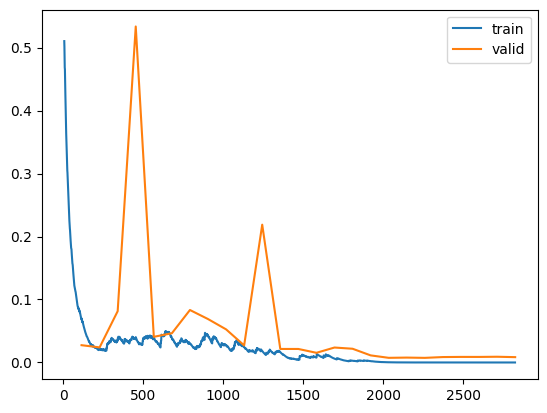

In [21]:
learn.recorder.plot_loss()

In [22]:
sensitivity = 1-learn.validate()[0]
specificity = learn.validate()[1]


In [23]:
#learn2 = learner.Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=[metrics.accuracy, metrics.error_rate, Precision, F1Score])

In [24]:
probs,targets = learn.get_preds() 


In [25]:
metrics.accuracy(probs,targets)


TensorBase(0.9978)

In [26]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'Normal']
print(classification_report(y_true1, y_pred1, target_names=target_names,digits=4))

910 908 0.9978021978021978
[[255   1]
 [  1 653]]
              precision    recall  f1-score   support

    Covid-19     0.9961    0.9961    0.9961       256
      Normal     0.9985    0.9985    0.9985       654

    accuracy                         0.9978       910
   macro avg     0.9973    0.9973    0.9973       910
weighted avg     0.9978    0.9978    0.9978       910



In [27]:
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.99609375
Specificity :  0.9984709480122325


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

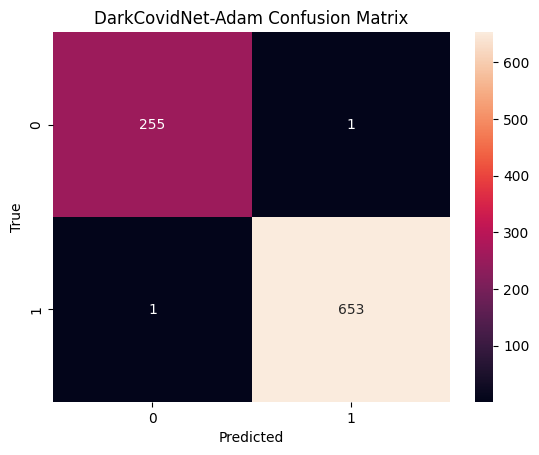

In [29]:
ax= plt.subplot()
sns.heatmap(cm1,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('DarkCovidNet-Adam Confusion Matrix'); 

In [33]:
fpr, tpr, threshold = roc_curve(probs, y_pred1, pos_label=1)

In [39]:
roc_auc = auc(fpr,tpr)

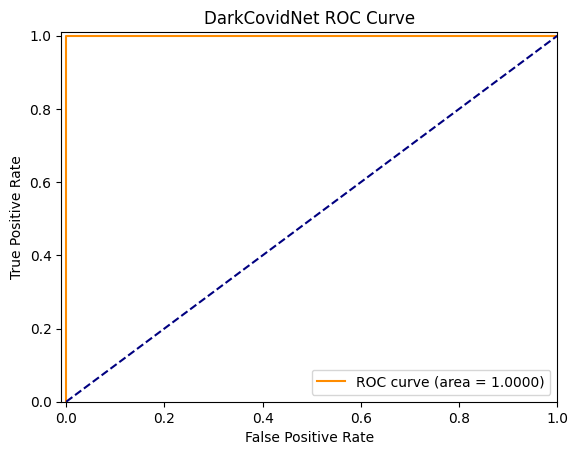

In [41]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DarkCovidNet ROC Curve')
plt.legend(loc="lower right")

# References

Muhammedtalo. (n.d.). Covid-19/DarkCovidNet for binary classes.ipynb at master · Muhammedtalo/covid-19. GitHub. Retrieved December 11, 2022, from https://github.com/muhammedtalo/COVID-19/blob/master/DarkCovidNet%20%20for%20binary%20classes.ipynb 

Mekarthikd. (2022, April 23). Dark-covid-net_ct-dataset. Kaggle. Retrieved December 11, 2022, from https://www.kaggle.com/code/mekarthikd/dark-covid-net-ct-dataset/script 

Parikh, R. (2020, July 13). DarkCovidNet: Automated detection of COVID-19 with X-ray images. Medium. Retrieved December 11, 2022, from https://medium.com/visionwizard/darkcovidnet-automated-detection-of-covid-19-with-x-ray-images-c4bfc29eb06c 
